# CS 132 Machine Project: Global Mean Sea Level (GMSL) Forecasting Using ARIMA

By: GROUP 1

**CRUEL, Nathaniel (2018-05737)**

**QUIRIM, Coleen (2018-05907)**

**SUMABAT, Carlo (2018-03037)**

**VIRTUCIO, Renzo (2018-03052)**

### PROBLEM STATEMENT

One severe side-effect of **global warming** is the **rising of sea levels** due to thermal expansion of the Earth's waters and melting of glaciers. With the increasing accessibility and innovation in data science technology, the researchers aimed to develop a **learning model** which can forecast the **global mean sea level in the following year**, based on historical sea level data. Aside from the potential of being able to forecast robustly, the forecasting model could serve as basis and inspiration in further scientific efforts to **address the environmental issues we face**. The data gathered from such forecasting models could guide not only scientists but also world leaders in dealing with the **possible effects of the rising sea levels**, such as the displacement of **coastal residences** and washing away **coastal animal habitats**.

### DATA SOURCE 

The data source for this project is the spreadsheet file *CSIRO_Recons_gmsl_yr_2019.csv*, which can be downloaded in the page of the article  <a href="https://www.cmar.csiro.au/sealevel/sl_hist_few_hundred.html" target="_blank">**“Historical Sea Level Changes”**</a> of the old CSIRO website. The exact download link is <a href="ftp://ftp.csiro.au/legresy/gmsl_files/CSIRO_Recons_gmsl_yr_2019.csv." target="_blank">*ftp://ftp.csiro.au/legresy/gmsl_files/CSIRO_Recons_gmsl_yr_2019.csv.*</a>

CSIRO stands for the Commonwealth Scientific and Industrial Research Organisation, a government agency in Australia that conducts scientific research. The spreedsheet file documents the **Global Mean Sea Level (GMSL)** in millimeters (mm) and the **GMSL uncertainty** in mm from **1880 to 2019**.


### DATA PROCESSING

Part of our data preprocessing is dropping the *GMSL uncertainty (mm)* column since we will be merely focusing on the values in the column **GMSL/Global Mean Sea Level in millimeters (mm)** from 1880 to 2019 in our project. We will ONLY be using these proper GMSL values for our predictions, so we disregard the uncertainty values.

Additionally, we also reformatted the values in the **Year** column by removing the fractional part **.5** at the end of the values under the Year column. Thus, 1880.5 was turned to 1880, 1881.5 to 1881, and so on and so forth. This is so we can better represent the exact years that the GMSL values were gathered from. 

In reading the comma-separated spreadsheet (csv) file into dataframe **df**, we also set the **Year** column as the **index values** for our dataframe by setting ***index_col*** to 0 (pertaining to our 0th column, Year). This makes our data of sea level measurements **indexed according to time, or in our case, according to the year**. Indexing our data set by the year makes time series analyis easier later.

We also check if our dataset has **missing values** by using the *isNa().sum()* function so we can perform data cleaning accordingly. The **isNa().sum()** function counts how many null/missing values there are in a dataframe. Since our result is 0, we have **NO missing values** in our dataset. Thus, no data cleaning is needed.

Later on, in the **Exploratory Data Analysis section**, we check if our time series data is stationary or not. If our data is found to be non-stationary, then we conduct another data preprocessing procedure called **differencing** to make our data stationary and thus more suitable for our forecasting model. We conduct differencing as many times as necessary to produce a stationary time series data.


In [68]:
import pandas as pd
import numpy as np

df = pd.read_csv("CSIRO_Recons_gmsl_yr_2019.csv", header=0, index_col=0)
df.drop(columns=["GMSL uncertainty (mm)"], axis=1, inplace=True)
df.index.names = ['Year']
df.rename(columns={"GMSL (mm)": "sea_level"}, inplace=True)

df.index = np.floor(df.index).astype(int)

print("Total null values\n", df.isna().sum())
df.head()

Total null values
 sea_level    0
dtype: int64


,sea_level
Year,
1880,-30.3
1881,-24.7
1882,-41.5
1883,-36.2
1884,-15.3


### EXPLORATORY DATA ANALYSIS (EDA)

In this project, we will use the **ARIMA** model in our time series forecasting. ARIMA stands for **Auto Regressive Integrated Moving Average** and is a model that utilizes past values in a time series data to forecast future values. This model is suitable for our data since our data is a collection of (sea level) measurements gathered at **regular, equally spaced intervals of time - every year**.

ARIMA is characterized by 3 terms - **order of the AR term (p), number of differencing (d), and order of the MA term (q)**. 

**AR (p)** is the **autoregressive part**. The order of the AR term or the **p** parameter is an integer that determines the **number of time periods or lagged series to be used** to forecast values in the time periods ahead.

The number of differencing or **d** parameter is an integer that determines the **number of differencing transformations** to be applied to make the time series stationary (if it is nonstationary).

**MA (q)** is the **moving average** model. The order of the MA term or the **q** parameter is the **number of lagged forecast errors** that should be considered in the ARIMA model.

#### To help us choose the most suitable values for the ARIMA parameters *p*, *d*, and *q*, we conduct exploratory data analysis (EDA) on our dataset so we can have a clearer and more concrete picture of how our data behaves.

--------------

**ADF Test**

To begin our EDA, we check first if our data (time series) is **stationary or non-stationary**. A **stationary time series has NO trend** and its **mean and variance are constant over time**. It is easier to predict when our time series is stationary. Models built on stationary data are generally more robust.

We want our time series variables to be **stationary** so the statistical properties of the model to be used **will NOT vary** depending on when the sample was taken. 

We use the **Augmented Dickey Fuller test (ADF test)** to check if our data is stationary or non-stationary. If **p value < 0.05**, our data is stationary and no differencing is needed. If **p value > 0.05**, then our data is non-stationary and we find a suitable order of differencing.  **Differencing** is only conducted on a non-stationary time series to make it stationary.

In [69]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df["sea_level"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.393374
p-value: 0.999007


**Finding a suitable number of differencing**

Since our computed **p-value = 0.999007 > 0.05**, we identify a number of differencing such that the plot of the differenced data is stationary. We observe that the plot of the original series shows an **upward trend**, implying that the values **increase** over time. This means our time series data is NOT stationary. This supports our ADF test earlier which showed that our time series is non-stationary.

We observe that the plot of the **first and second order differencing** appear to be **stationary** compared to the original series. We thus choose the number of differencing to be **2**. 

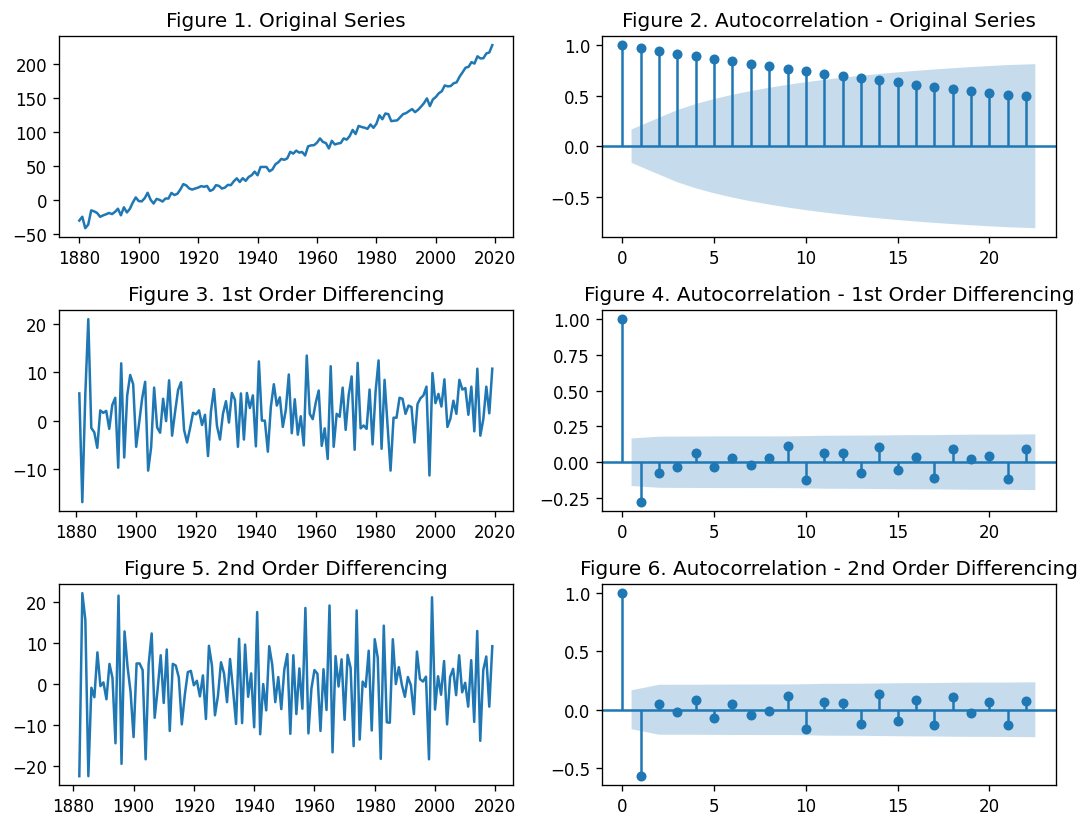

In [70]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df["sea_level"]); axes[0, 0].set_title('Figure 1. Original Series')
plot_acf(df["sea_level"], ax=axes[0, 1]); axes[0, 1].set_title('Figure 2. Autocorrelation - Original Series')

# 1st Differencing
axes[1, 0].plot(df["sea_level"].diff()); axes[1, 0].set_title('Figure 3. 1st Order Differencing')
plot_acf(df["sea_level"].diff().dropna(), ax=axes[1, 1]); axes[1, 1].set_title('Figure 4. Autocorrelation - 1st Order Differencing')

# 2nd Differencing
axes[2, 0].plot(df["sea_level"].diff().diff()); axes[2, 0].set_title('Figure 5. 2nd Order Differencing')
plot_acf(df["sea_level"].diff().diff().dropna(), ax=axes[2, 1]); axes[2, 1].set_title('Figure 6. Autocorrelation - 2nd Order Differencing')

fig.tight_layout()
plt.show()

**Find the order of the AR term (p)**

We identify a possible order of the **AR term** by observing the **partial autocorrelation plot** of the second order differencing. We observe that the **PACF lag 1** is quite **significant** since it is **well below the significance line** (past the blue shaded area). We thus take the order of the **AR term** to be **1**.

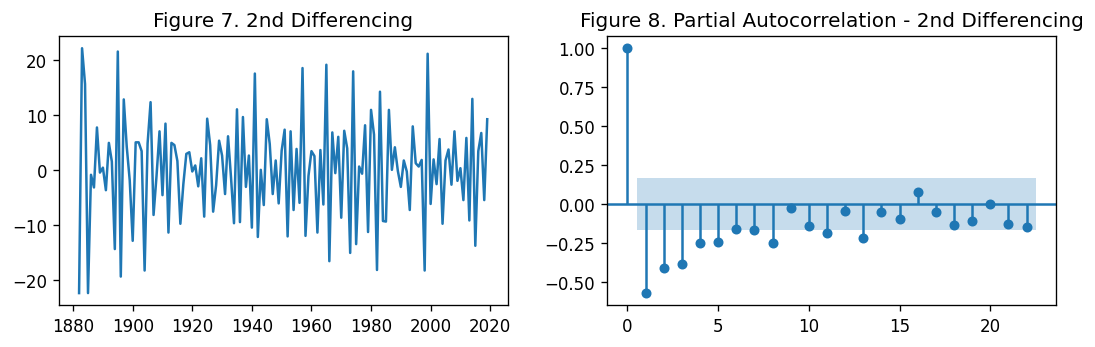

In [71]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
# axes[0].set_xlim([1880, 2019])
axes[0].plot(df["sea_level"].diff().diff()); axes[0].set_title('Figure 7. 2nd Differencing')
plot_pacf(df["sea_level"].diff().diff().dropna(), ax=axes[1]); axes[1].set_title('Figure 8. Partial Autocorrelation - 2nd Differencing')

fig.tight_layout()
plt.show()

**Finding the order of the MA term (q)**

We identify a possible order of the **MA term** by observing the **autocorrelation plot** of the second order differencing. We observe that the **ACF lag 1** is quite **significant** since it is **well below the significance line** (past the blue shaded area). We thus take the **order of the MA term** to be **1**.

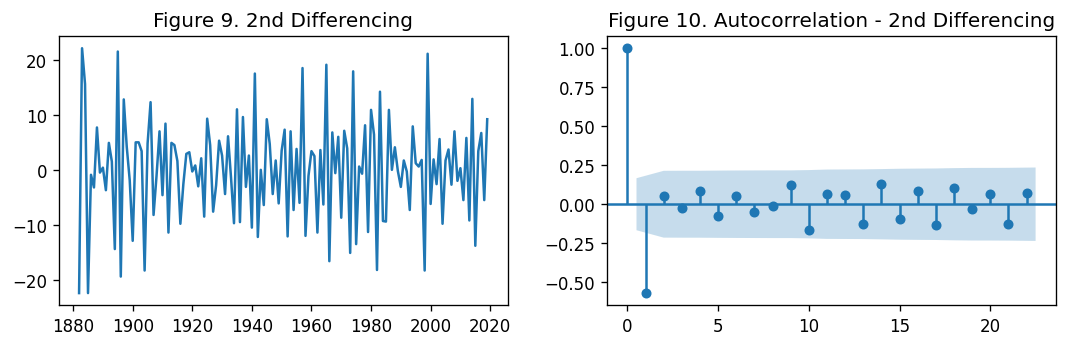

In [72]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df["sea_level"].diff().diff()); axes[0].set_title('Figure 9. 2nd Differencing')
plot_acf(df["sea_level"].diff().diff().dropna(), ax=axes[1]); axes[1].set_title('Figure 10. Autocorrelation - 2nd Differencing')
fig.tight_layout()
plt.show()

### MODELLING

Based on our exploratory data analysis (EDA) earlier, we set **1** as the **order of the AR term (p**), **2** as the **order of differencing (d)**, and **1** as the **order of the MA term (q)**. 

We now use these values to build our ARIMA model.

In [73]:
from statsmodels.tsa.arima.model import ARIMA
# prepare training dataset
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
arima_model = None
predictions = list()
for t in range(len(test)):
    arima_model = ARIMA(history, order=(1,2,1)) # 1 as the order of AR term (p), 2 as the order of differencing (d), and 1 as the order of MA term (q)
    arima_model_fit = arima_model.fit()
    yhat = arima_model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

### RESULTS AND DISCUSSION

**Plotting the residuals**

We create a **residual plot** and a **kernel density estimate plot** from the residuals obtained as we forecasted using our ARIMA model. Note that a **residual** is the **actual value subtracted by the forecasted or predicted value**. We observe from the residual plot that the residuals are **scattered randomly** around the residual=0 line (y=0). On the other hand, we observe that the kernel distribution estimate plot has a **near-zero mean and a low standard deviation**. These plots indicate that the forecasts made by our ARIMA model are **close to the actual recorded data**.

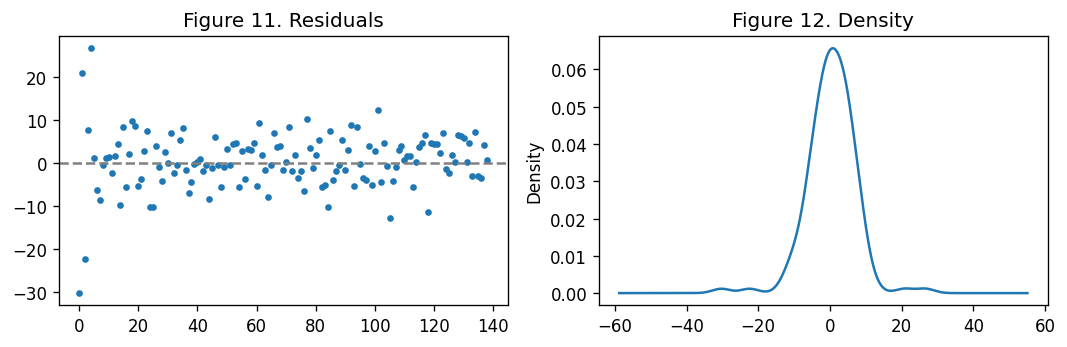

In [74]:
# Plot residual errors
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(arima_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Figure 11. Residuals", ax=ax[0], marker='.', linestyle='')
ax[0].axhline(y=0, color='grey', linestyle='--')
residuals.plot(kind='kde', title='Figure 12. Density', ax=ax[1])
fig.tight_layout()
ax[0].get_legend().remove()
ax[1].get_legend().remove()
plt.show()

**Plotting the forecasts of our ARIMA model against the actual data**

Figure 13 plots the **actual GMSL data** (blue) from 1880 to 2019 and **predicted GMSL data** (red) from 1972 to 2019. It can be seen that the plot of our predicted GMSL values from 1972 to 2019 (red) follows the **same upward trend** as the plot of the actual GMSL values in the same period. Additionally, the plot of our predicted values are **positioned closely and similarly** to the plot of the actual values, which means that the data points in our prediction are **close to the recorded data points during these years**.

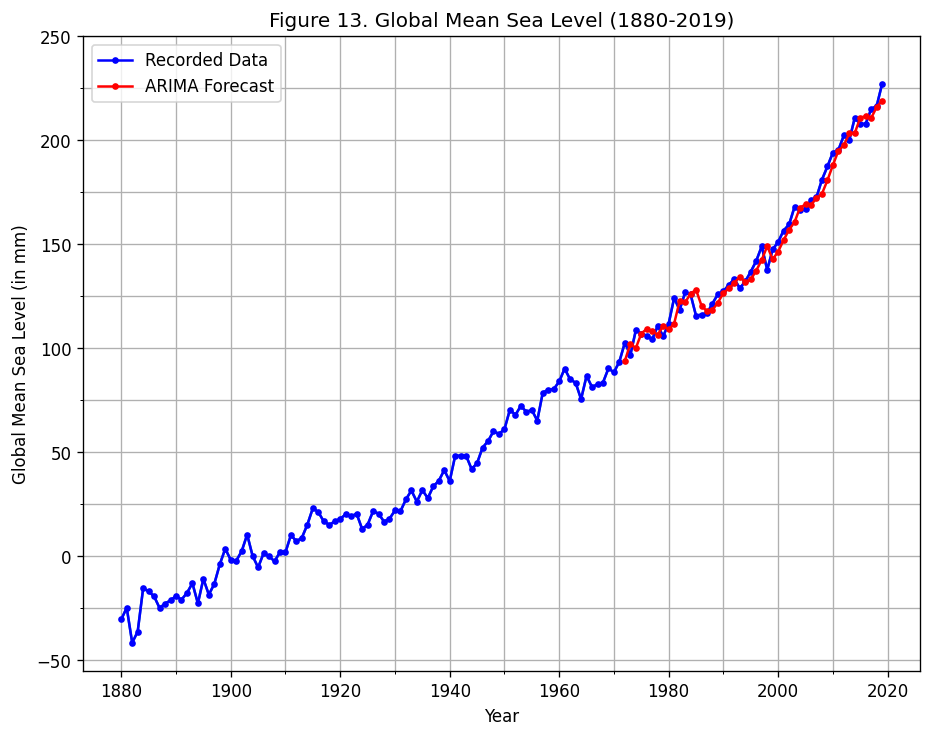

In [75]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, ax = plt.subplots()

ax.plot(df["sea_level"])

x = [i for i in range(1972, 2020)]
y = predictions
ax.plot(df["sea_level"], label='Recorded Data', color='blue', marker='.')
ax.plot(x, y, label='ARIMA Forecast', color='red', marker='.')
ax.set_yticks(np.arange(-50, 251, 25), minor=True)
ax.set_xticks(np.arange(1880, 2021, 10), minor=True)


# Labelling 

plt.xlabel("Year")
plt.ylabel("Global Mean Sea Level (in mm)")
plt.title("Figure 13. Global Mean Sea Level (1880-2019)")

# Display
plt.legend()
plt.grid(linestyle='-', which='both')
plt.show()


**Measuring the performance of our ARIMA model**

We measure the performance of our ARIMA model using the following metrics: **Mean Absolute Percentage Error** and the **Root Mean Square Error**. The **Mean Absolute Percentage Error** of our ARIMA model is ~0.03135 or **~3.135%** which means it is about **96.865% accurate** in predicting the Global Mean Sea Level from 1972 to 2019. The **Root Mean Square Error**, which is also the standard deviation of the residuals, of our ARIMA model is **~5.308**. For both metrics, **lower values generally indicate better performance**.

In [76]:
from statsmodels.tsa.stattools import acf
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'rmse':rmse})

forecast_accuracy(np.array([[i] for i in predictions]), test)

{'mape': 0.031354766210906326, 'rmse': 5.308252916978366}

**Forecasting the GMSL in 2020**

Recall that the dataset we used only include the GMSL in years spanning from **1880 to 2019**. Since our ARIMA model can forecast the GMSL in the year that is **one step ahead of the historical data**, we can forecast the GMSL in **2020**. We notice an increase of roughly **8 mm** in 2020 from our ARIMA model's GMSL forecast for 2019, from ***219.16 mm*** in 2019 to ***227.57 mm*** in 2020.

In [77]:
arima_model = ARIMA(history, order=(1,2,1))
arima_model_fit = arima_model.fit()
gmsl_forecast_2020 = arima_model_fit.forecast()[0]

print(f"GMSL in 2019: {predictions[-1]}, GMSL in 2020: {gmsl_forecast_2020}")

GMSL in 2019: 219.16436327515999, GMSL in 2020: 227.5703276389291


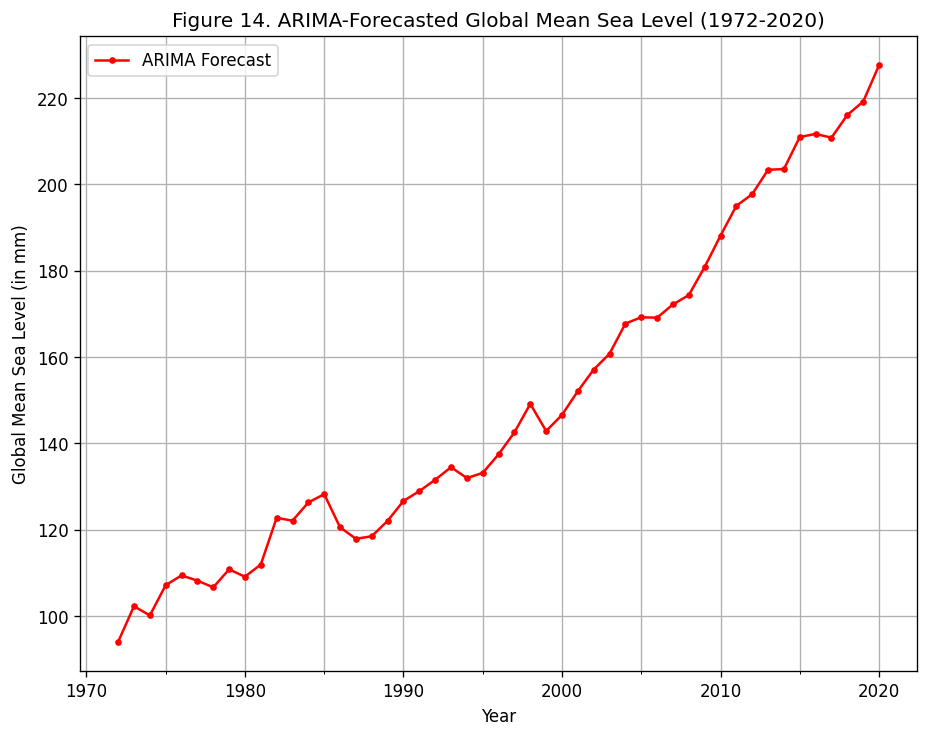

In [78]:
arima_model = ARIMA(history, order=(1,2,1))
arima_model_fit = arima_model.fit()

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, ax = plt.subplots()

x = [i for i in range(1972, 2021)]
y = predictions + [gmsl_forecast_2020]
ax.plot(x, y, label='ARIMA Forecast', color='red', marker='.')
ax.set_xticks(np.arange(1970, 2021, 5), minor=True)

# Labelling 

plt.xlabel("Year")
plt.ylabel("Global Mean Sea Level (in mm)")
plt.title("Figure 14. ARIMA-Forecasted Global Mean Sea Level (1972-2020)")

# Display
plt.legend()
plt.grid(linestyle='-', which='both')
plt.show()


### CONCLUSION

- Based on the Figure 13 plot of the **actual GMSL data** (blue line) from 1880 to 2019 and the **predicted GMSL data** (red line) from 1972 to 2019, the **predicted GMSL values** follow the **same upward trend** and are **close to the recorded GMSL values** during the same time period. Our ARIMA model also obtained a **Mean Absolute Percentage Error of ~3.135%**, implying about **96.865% accuracy** in predicting the Global Mean Sea Level in the years 1972-2019. On top of that, our model obtained a **Root Mean Square Error of ~5.308**. Both metrics are indicative of **good performance** for our chosen dataset. 

- This suggests that the **parameters** chosen for the ARIMA model ***(p = 1, d = 2, q = 1)*** are very **suitable** for the chosen dataset. Hence, the **exploratory data analysis (EDA)** procedures conducted were successful in revealing the **prominent characteristics and patterns** in our dataset, such as it being **non-stationary** and having a **general upward trend**. This led to conducting **suitable data preprocessing** such as **2nd order differencing** to make the time series data stationary. Additionally, the EDA served as a **reliable basis** in choosing the **appropriate ARIMA parameters**.

- Given the trends shown by our predictions, we can assume that the GMSL values will **continue to increase** in the years beyond 2019. In fact, the predicted GMSL value in **2020** is roughly an **8 mm** increase from the 2019 predicted value. Like in the past years, the intervals among the GMSL values in the coming years might show signs of **inconsistency** (up-down-up line or irregular value gaps), but the **general trend** of the future data will highly likely be still **upwards/increasing**, unless some major climate interventions take place.

- With this in mind, without solid efforts to mitigate climate change, the **increasing global mean sea level** will cause harm to **more and more coastal human residences and coastal animal habitats**, affecting many human livelihoods and wildlife. Thus, country leaders, scientific organizations, and corporations should consider the **climate crisis an urgent international concern** and must dedicate themselves in continuously **crafting concrete measures** that help **mitigate global warming** and **adapt to the rising global temperatures and its alarming effects**.

